# 1. Set up and loading data


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Cấu hình hiển thị
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)

train = pd.read_csv(r'D:\Topic_13_Project\Topic_13_Retail_Store_Sales_Time_Series\data\processed\train_cleaned.csv', parse_dates=["date"])
oil = pd.read_csv(r'D:\Topic_13_Project\Topic_13_Retail_Store_Sales_Time_Series\data\processed\cleaned_oil.csv', parse_dates=["date"])
holidays = pd.read_csv(r'D:\Topic_13_Project\Topic_13_Retail_Store_Sales_Time_Series\data\processed\holidays_events_cleaned.csv.csv', parse_dates=["date"])

# 2.Data Preparation

2.1 Oil Prices (Interpolate)

In [19]:
oil = oil.set_index("date").asfreq("D")
oil["dcoilwtico"] = oil["dcoilwtico"].interpolate(method="linear", limit_direction="both").ffill().bfill()
oil = oil.reset_index()

2.2 Holidays Clean Up & Categorization

In [20]:
# Đảm bảo cột transferred là boolean
holidays['transferred'] = holidays['transferred'].astype(bool)

# Logic phân loại:
# 1. Loại bỏ ngày 'Transferred' (bị dời đi -> đi làm bình thường)
# 2. Loại bỏ ngày 'Work Day' (làm bù -> không phải lễ)
holidays = holidays[(holidays['transferred'] == False) & (holidays['type'] != 'Work Day')]

# Ưu tiên: National > Regional > Local
priority_map = {'National': 1, 'Regional': 2, 'Local': 3}
holidays['priority'] = holidays['locale'].map(priority_map)
holidays = holidays.sort_values(by=['date', 'priority'])

# Deduplicate: Giữ lại sự kiện quan trọng nhất trong ngày
holidays_unique = holidays.drop_duplicates(subset=['date'], keep='first')

2.3 Main Merge 

In [21]:
# Gom nhóm sales theo ngày (Tổng sales toàn quốc - Macro View)
daily_sales = train.groupby("date")["sales"].sum().reset_index()

# Merge Oil & Holidays
df = daily_sales.merge(oil, on="date", how="left")
df = df.merge(holidays_unique[['date', 'type', 'locale', 'description']], 
              on="date", how="left")

2.4 Feature Engineering

In [22]:
# Basic Flags
df['holiday_type'] = df['type'].fillna('Normal Day')
df['locale_category'] = df['locale'].fillna('None')
df['is_holiday_event'] = df['type'].notna()

# Flag Window (Before/During/After) - Vectorized approach (Tối ưu tốc độ)
holiday_dates = df[df['is_holiday_event']]['date']
df['period_type'] = 'Normal'

# Flag Lag Oil
for lag in [1, 7, 14, 30, 365]:
    df[f'oil_lag_{lag}'] = df['dcoilwtico'].shift(lag)
    df[f'sales_lag_{lag}'] = df['sales'].shift(lag) # Lag cho cả sales để so sánh

print("Data Preparation Completed.")

Data Preparation Completed.


# 3. VISUALIZATIONS

3.1 OIL ANALYSIS

C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_34920\1919259257.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f'Lag {l}' for l in lags], y=corrs, ax=axes[2], palette='Reds')


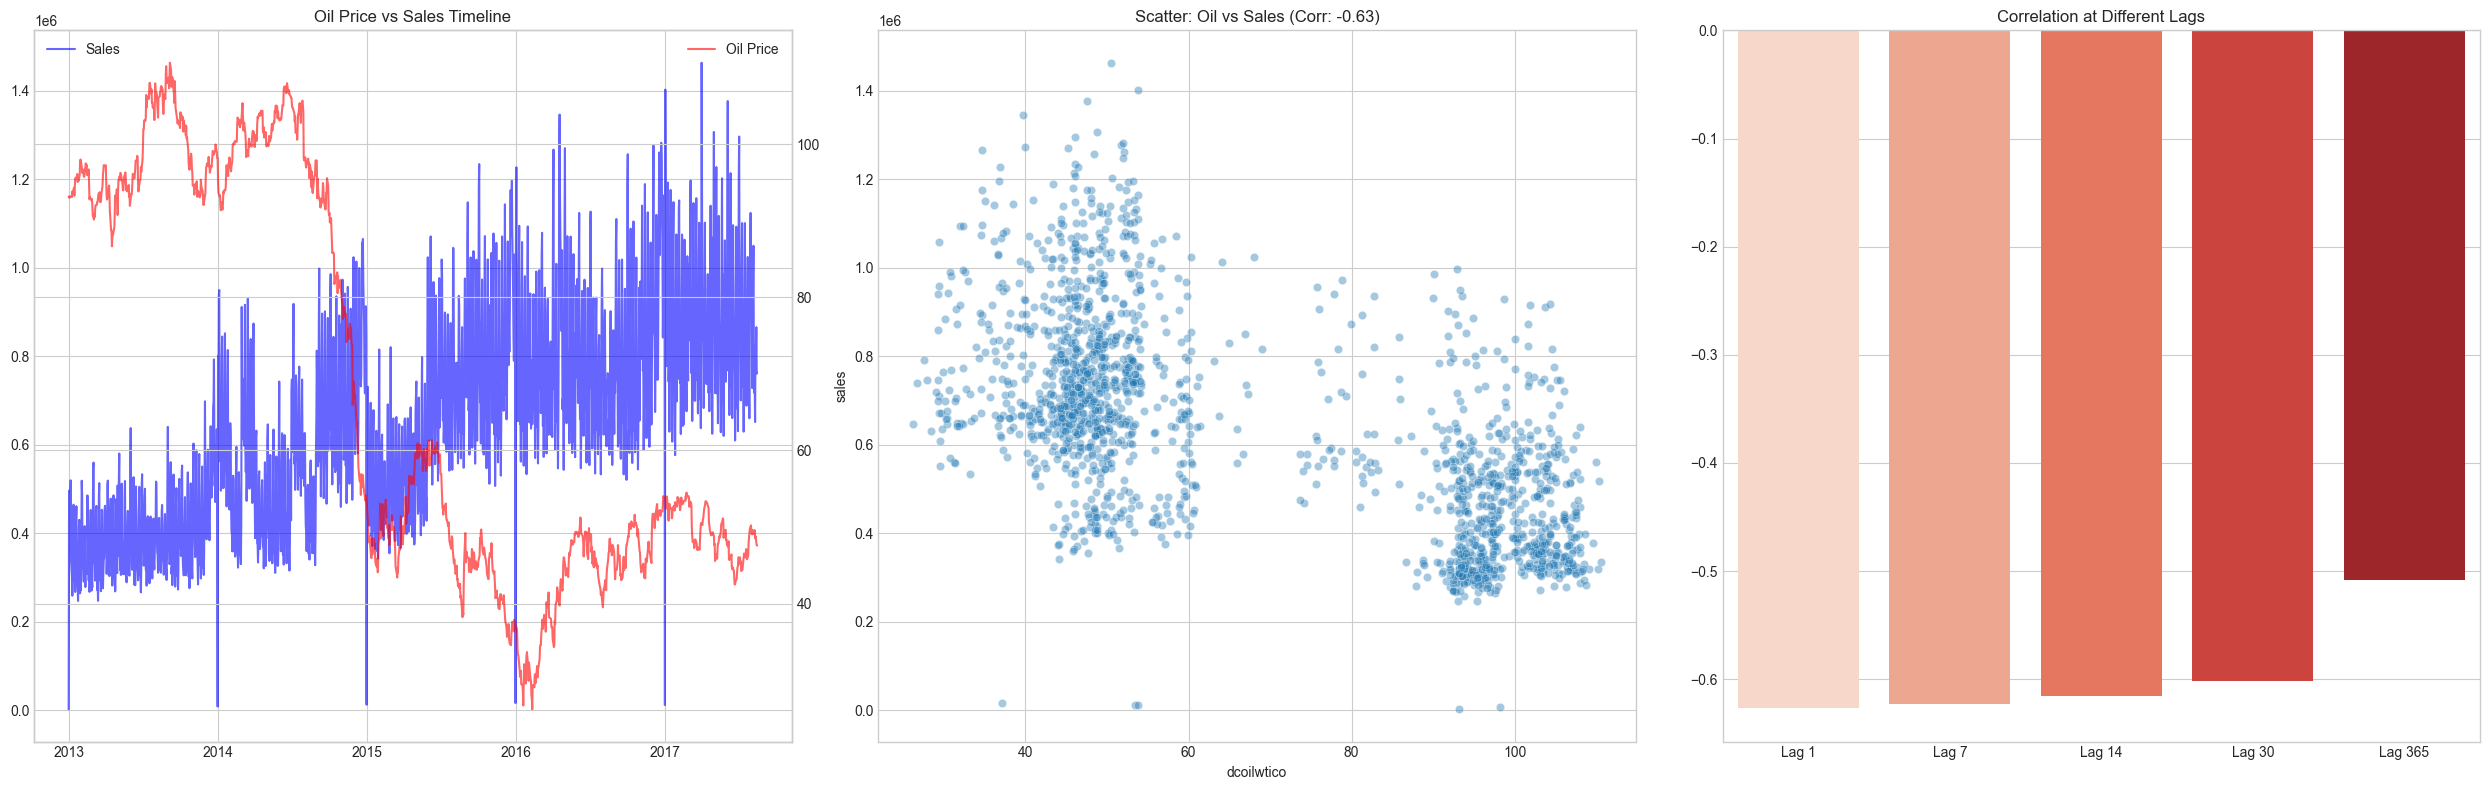

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(25, 8))

# A. Line Chart Overlay
ax1 = axes[0]
ax1.plot(df['date'], df['sales'], color='blue', alpha=0.6, label='Sales')
ax2 = ax1.twinx()
ax2.plot(df['date'], df['dcoilwtico'], color='red', alpha=0.6, label='Oil Price')
ax1.set_title("Oil Price vs Sales Timeline")
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# B. Scatter Plot
sns.scatterplot(data=df, x='dcoilwtico', y='sales', ax=axes[1], alpha=0.4)
axes[1].set_title(f"Scatter: Oil vs Sales (Corr: {df['sales'].corr(df['dcoilwtico']):.2f})")

# C. Lag Correlation Bar Chart
lags = [1, 7, 14, 30, 365]
corrs = [df['sales'].corr(df[f'oil_lag_{l}']) for l in lags]
sns.barplot(x=[f'Lag {l}' for l in lags], y=corrs, ax=axes[2], palette='Reds')
axes[2].set_title("Correlation at Different Lags")
plt.tight_layout()
plt.show()

3.2 HOLIDAY ANALYSIS: TYPES & REGIONAL

C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_34920\3578624429.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='holiday_category', y='sales', order=type_order, ax=axes[0, 1], palette='viridis')
C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_34920\3578624429.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df[df['locale_category']!='None'], x='locale_category', y='sales', order=locale_order, ax=axes[1, 0], palette='magma')


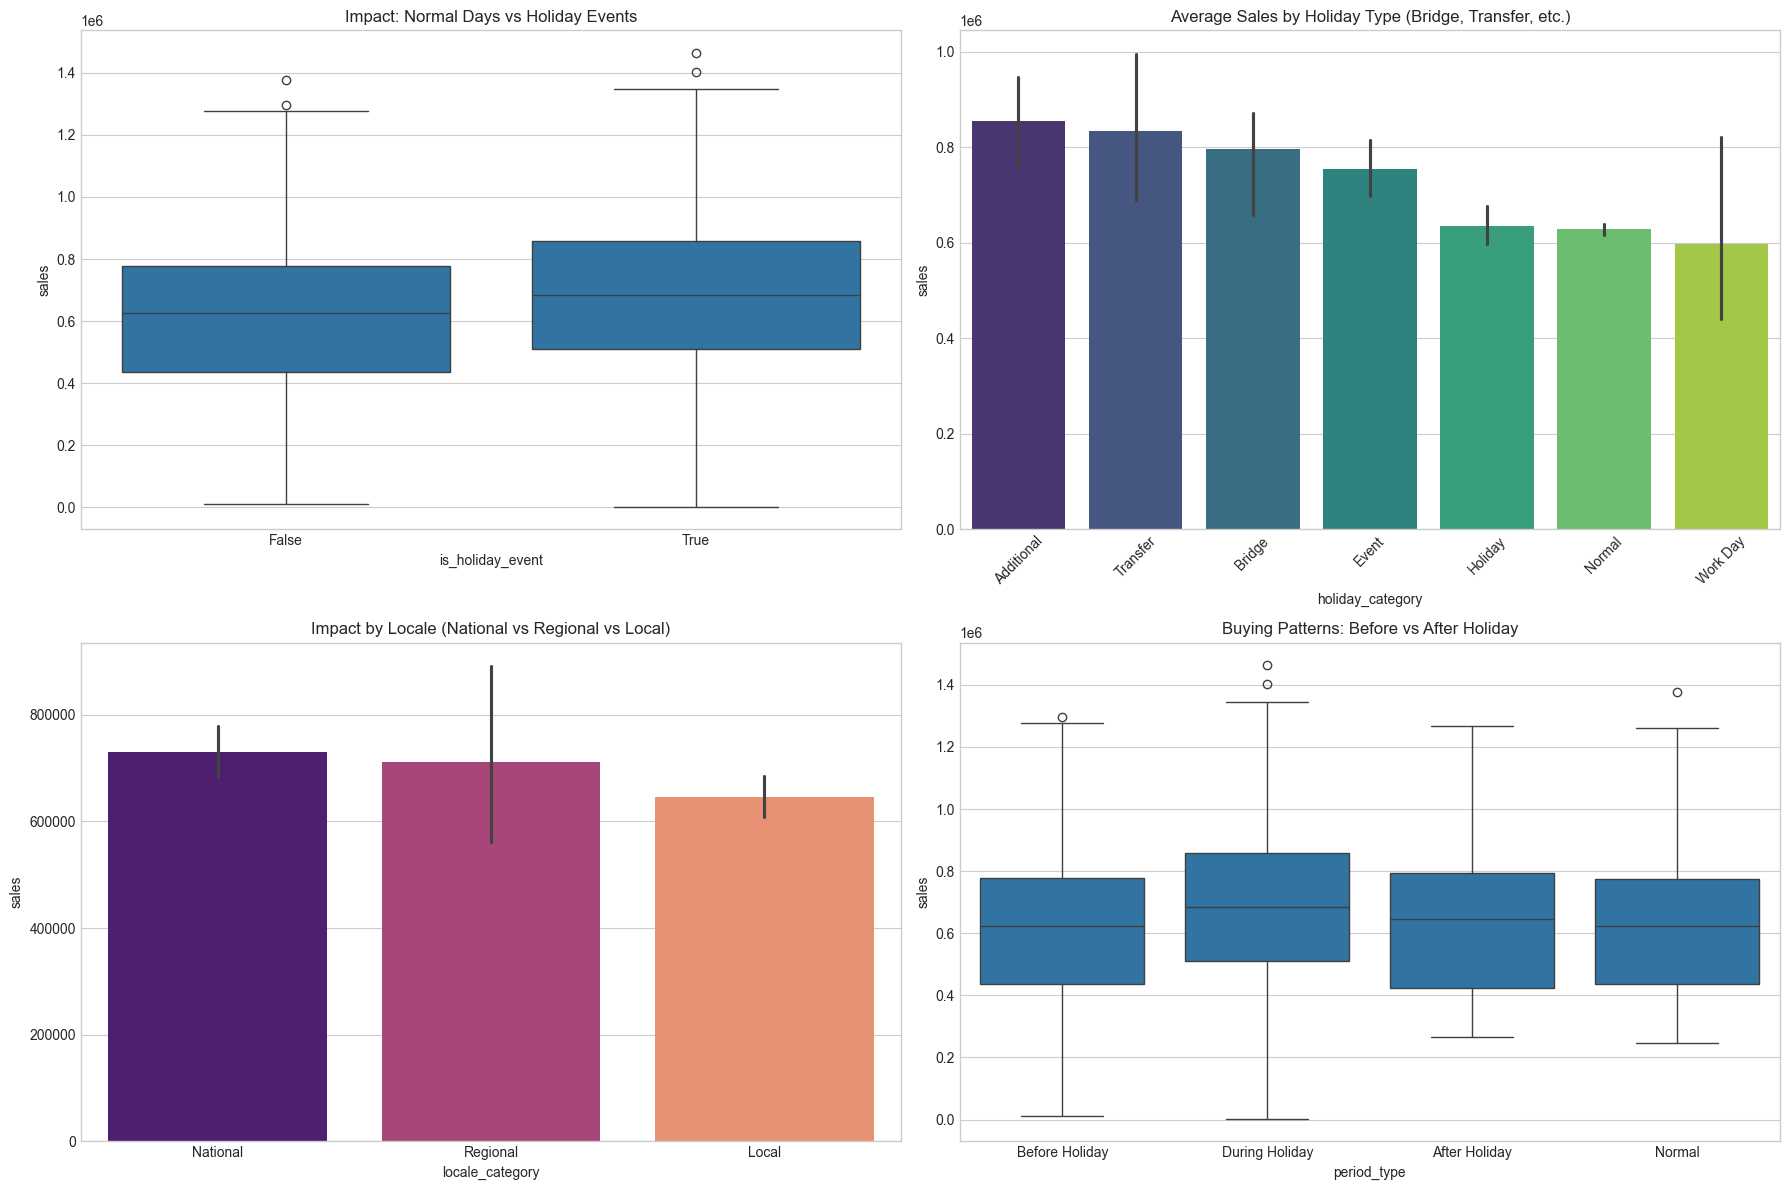

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# A. Boxplot Normal vs Holiday
sns.boxplot(data=df, x='is_holiday_event', y='sales', ax=axes[0, 0])
axes[0, 0].set_title("Impact: Normal Days vs Holiday Events")

# B. Bar Chart: Holiday Types
type_order = df.groupby('holiday_type')['sales'].mean().sort_values(ascending=False).index
sns.barplot(data=df, x='holiday_type', y='sales', order=type_order, ax=axes[0, 1], palette='viridis')
axes[0, 1].set_title("Average Sales by Holiday Type")
axes[0, 1].tick_params(axis='x', rotation=45)

# C. Bar Chart: Locale Impact
locale_order = df[df['locale_category']!='None'].groupby('locale_category')['sales'].mean().sort_values(ascending=False).index
sns.barplot(data=df[df['locale_category']!='None'], x='locale_category', y='sales', order=locale_order, ax=axes[1, 0], palette='magma')
axes[1, 0].set_title("Impact by Locale")

# D. Sales Pattern: Before/During/After
order_period = ['Before Holiday', 'During Holiday', 'After Holiday', 'Normal']
sns.boxplot(data=df, x='period_type', y='sales', order=order_period, ax=axes[1, 1])
axes[1, 1].set_title("Buying Patterns: Before vs After Holiday")

plt.tight_layout()
plt.show()

3.3 CALENDAR HEATMAP

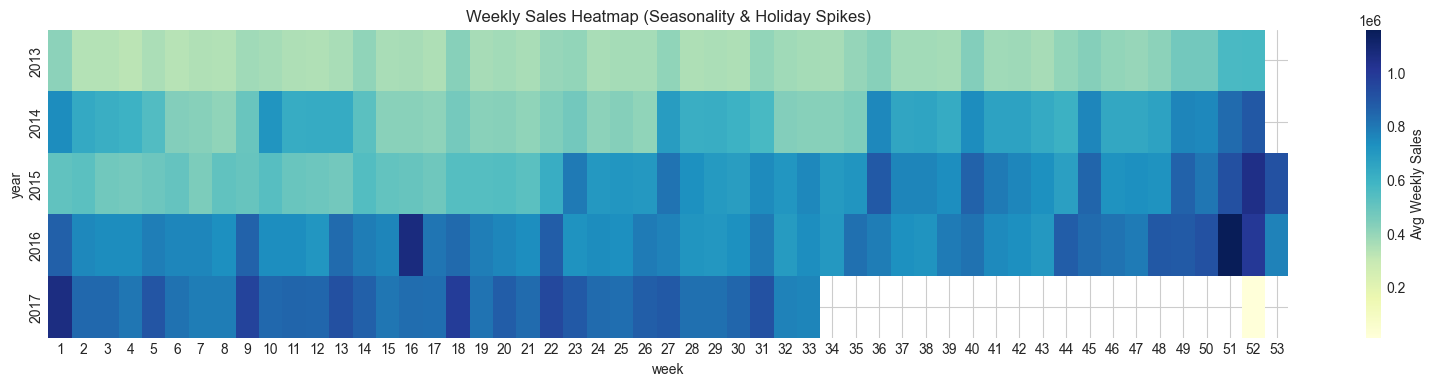

In [25]:
df['year'] = df['date'].dt.year
df['week'] = df['date'].dt.isocalendar().week
pivot_sales = df.pivot_table(index='year', columns='week', values='sales', aggfunc='mean')

plt.figure(figsize=(20, 4))
sns.heatmap(pivot_sales, cmap='YlGnBu', cbar_kws={'label': 'Avg Weekly Sales'})
plt.title("Weekly Sales Heatmap (Seasonality)")
plt.show()

3.4 EVENT ANALYSIS: EARTHQUAKE & ANOMALIES

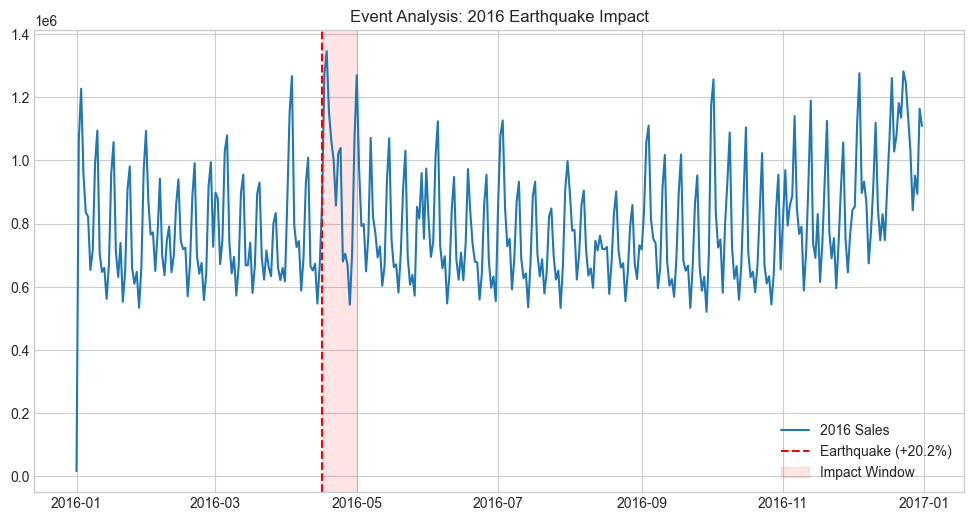

In [26]:
earthquake_date = pd.to_datetime("2016-04-16")
window = 15
before = df[(df['date'] < earthquake_date) & (df['date'] >= earthquake_date - pd.Timedelta(days=window))]['sales'].mean()
after = df[(df['date'] > earthquake_date) & (df['date'] <= earthquake_date + pd.Timedelta(days=window))]['sales'].mean()
growth = (after - before) / before * 100

plt.figure(figsize=(12, 6))
subset = df[(df['date'].dt.year == 2016)]
plt.plot(subset['date'], subset['sales'], label='2016 Sales')
plt.axvline(earthquake_date, color='red', linestyle='--', label=f'Earthquake (+{growth:.1f}%)')
plt.axvspan(earthquake_date, earthquake_date + pd.Timedelta(days=window), color='red', alpha=0.1)
plt.title("Event Analysis: 2016 Earthquake Impact")
plt.legend()
plt.show()

3.5 ADVANCED TIME SERIES PLOTS


--- Generating STL & ACF/PACF Analysis ---


C:\Users\Acer\AppData\Local\Temp\ipykernel_3768\499576916.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts_data = df.set_index('date')['sales'].asfreq('D').fillna(method='ffill')


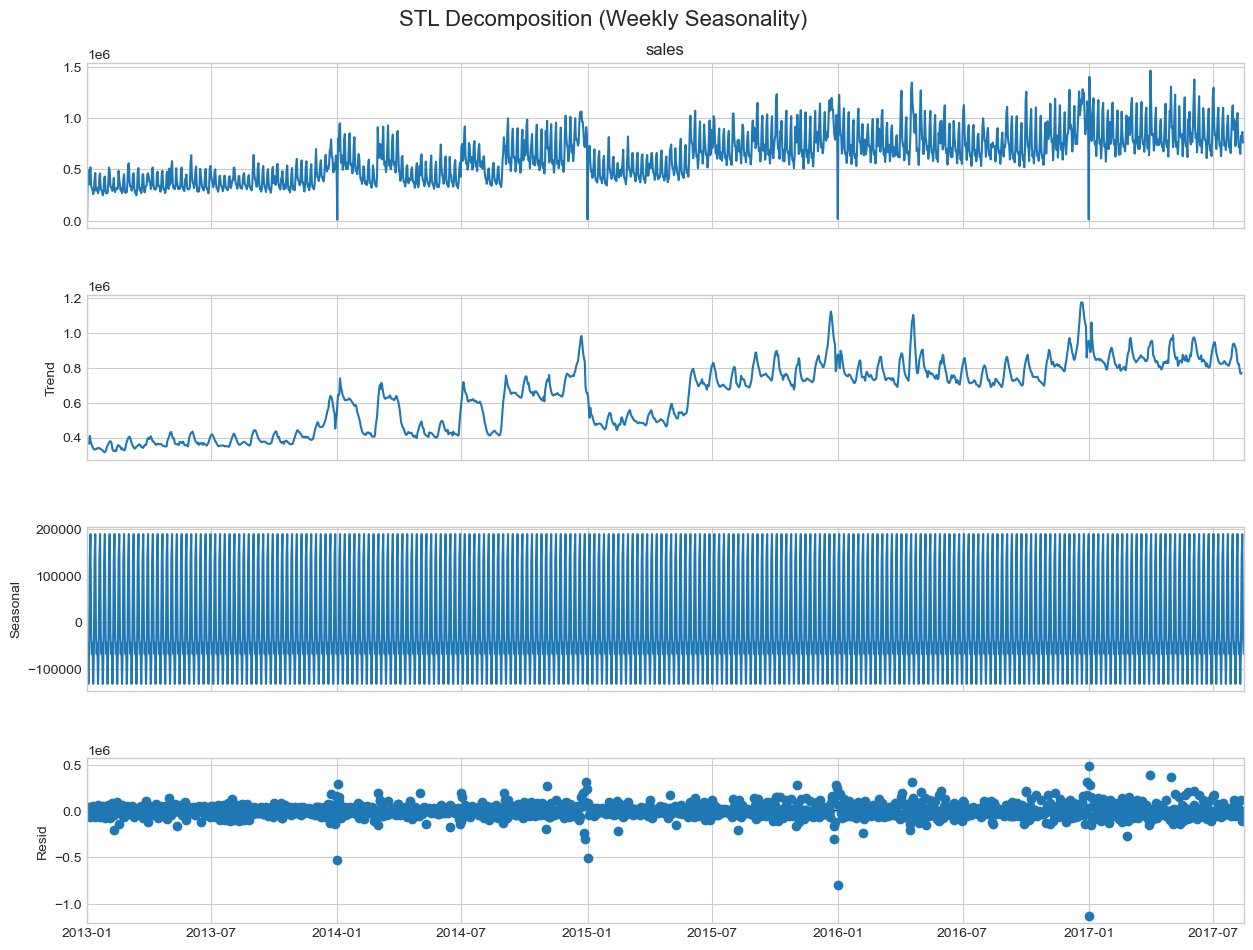

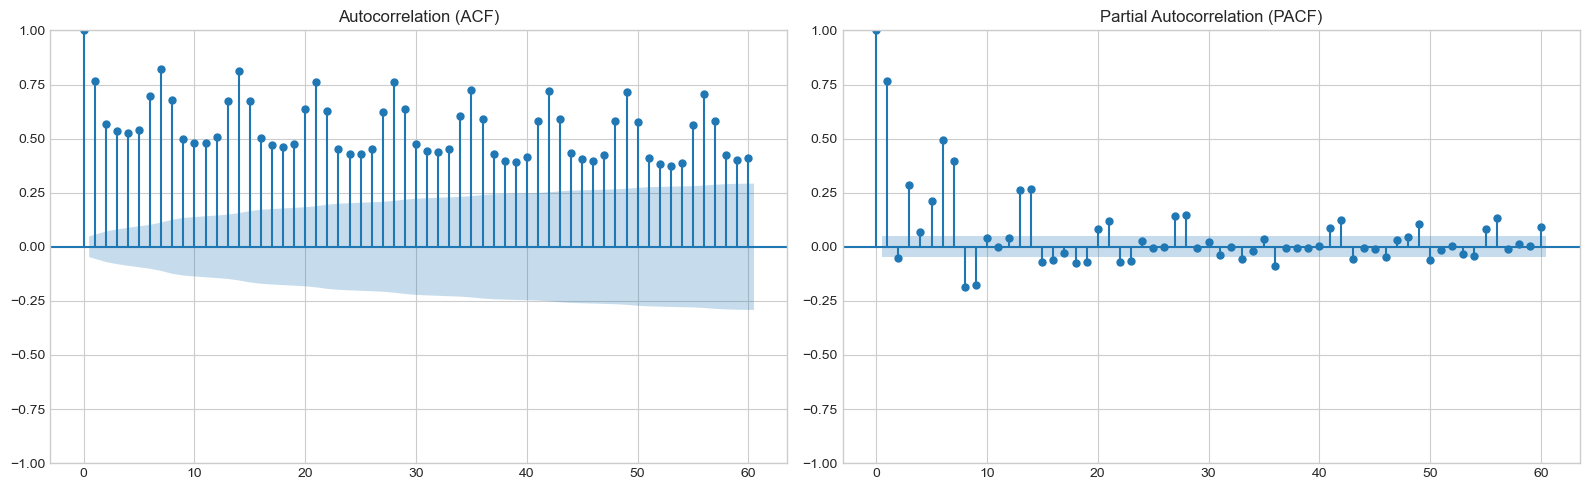

In [27]:
print("\n--- Generating STL & ACF/PACF Analysis ---")

# Chuẩn bị dữ liệu Time Series
ts_data = df.set_index('date')['sales'].asfreq('D').fillna(method='ffill')

# STL Decomposition (Chu kỳ tuần = 7)
res_week = seasonal_decompose(ts_data, model='additive', period=7)
fig = res_week.plot()
fig.set_size_inches(14, 10)
fig.suptitle("STL Decomposition (Weekly Seasonality)", fontsize=16)
plt.show()

# ACF & PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(ts_data.dropna(), lags=60, ax=axes[0]) 
axes[0].set_title("Autocorrelation (ACF)")
plot_pacf(ts_data.dropna(), lags=60, ax=axes[1], method='ywm')
axes[1].set_title("Partial Autocorrelation (PACF)")
plt.tight_layout()
plt.show()